In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.neural_network import MLPRegressor
from fbprophet import Prophet
plt.style.use('fivethirtyeight')

Importing plotly failed. Interactive plots will not work.


In [2]:
# read data and convert string to date
speed = pd.read_csv('train.csv')
speed['date']=pd.to_datetime(speed['date'],format='%d/%m/%Y %H:%M')
speed.set_index('date', inplace=True) 
speed = speed.drop(columns='id',axis= 1)
speed.head()

,speed
date,
2017-01-01 00:00:00,43.002930
2017-01-01 01:00:00,46.118696
2017-01-01 02:00:00,44.294158
2017-01-01 03:00:00,41.067468
2017-01-01 04:00:00,46.448653


In [3]:
# Creates time series features from datetime index
def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

In [4]:
X_train, y_train = create_features(speed, label='speed')

In [5]:
y_train

date
2017-01-01 00:00:00    43.002930
2017-01-01 01:00:00    46.118696
2017-01-01 02:00:00    44.294158
2017-01-01 03:00:00    41.067468
2017-01-01 04:00:00    46.448653
                         ...    
2018-12-31 12:00:00    19.865269
2018-12-31 15:00:00    17.820375
2018-12-31 16:00:00    12.501851
2018-12-31 18:00:00    15.979319
2018-12-31 20:00:00    40.594183
Name: speed, Length: 14006, dtype: float64

# xgboost

In [19]:
#use xgboost to train the model
reg = xgb.XGBRegressor(n_estimators=300, reg_alpha=0.1, reg_lambda=0.5)
#n_estimators=300, reg_alpha=0.1, reg_lambda=0.5
#n_estimators=300, reg_alpha=0.1, reg_lambda=0.5, gamma=0.45
reg.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=10,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=80, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0.1, reg_lambda=0.5, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [13]:
# reg = MLPRegressor(alpha=1e-5, hidden_layer_sizes=(256,128,64,10), max_iter=400, learning_rate_init=0.005)

# reg.fit(X_train, y_train)

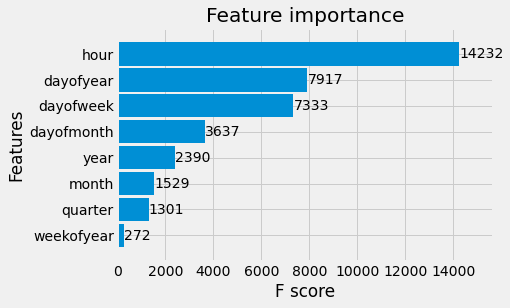

In [20]:
_ = plot_importance(reg, height=0.9)

In [21]:
# read test data and predict
ts = pd.read_csv('test.csv')
ts['date'] = pd.to_datetime(ts['date'],format='%d/%m/%Y %H:%M')
ts.set_index('date', inplace=True) 
# ts = ts.drop(columns='id',axis= 1)
X_ts = create_features(ts)
ts['speed'] = reg.predict(X_ts)


ts.head()

,id,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,speed
date,,,,,,,,,,,
2018-01-01 02:00:00,0,2018-01-01 02:00:00,2,0,1,1,2018,1,1,1,49.400734
2018-01-01 05:00:00,1,2018-01-01 05:00:00,5,0,1,1,2018,1,1,1,47.420162
2018-01-01 07:00:00,2,2018-01-01 07:00:00,7,0,1,1,2018,1,1,1,37.600574
2018-01-01 08:00:00,3,2018-01-01 08:00:00,8,0,1,1,2018,1,1,1,30.200569
2018-01-01 10:00:00,4,2018-01-01 10:00:00,10,0,1,1,2018,1,1,1,42.712769


In [22]:
output = ts[['id','speed']]
output.head()

,id,speed
date,,
2018-01-01 02:00:00,0,49.400734
2018-01-01 05:00:00,1,47.420162
2018-01-01 07:00:00,2,37.600574
2018-01-01 08:00:00,3,30.200569
2018-01-01 10:00:00,4,42.712769


In [23]:
output.set_index('id', inplace=True) 
output.head()

,speed
id,
0,49.400734
1,47.420162
2,37.600574
3,30.200569
4,42.712769


In [24]:
output.to_csv('output31.csv')

# Prophet 

In [24]:
speed = pd.read_csv('train.csv')
speed['date']=pd.to_datetime(speed['date'],format='%d/%m/%Y %H:%M')
speed.rename(columns = {"date": "ds", "speed":"y"},  inplace=True)
# speed.set_index('ds', inplace=True) 
# speed = speed.drop(columns='id',axis= 1)
speed.head()

,id,ds,y
0,0,2017-01-01 00:00:00,43.002930
1,1,2017-01-01 01:00:00,46.118696
2,2,2017-01-01 02:00:00,44.294158
3,3,2017-01-01 03:00:00,41.067468
4,4,2017-01-01 04:00:00,46.448653


In [34]:
# features_and_target = pd.concat([X_train, y_train], axis=1).rename(columns={'date':'ds',
#                      'speed':'y'})
# features_and_target.head()
reg = Prophet(yearly_seasonality=True)
reg.fit(speed)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [35]:
ts = pd.read_csv('test.csv')
ts['date'] = pd.to_datetime(ts['date'],format='%d/%m/%Y %H:%M')
ts.rename(columns = {"date": "ds"},  inplace=True)
# ts.set_index('date', inplace=True) 
# # ts = ts.drop(columns='id',axis= 1)
# X_ts = create_features(ts)
fore = reg.predict(ts)
ts['speed'] = fore['yhat']
ts.rename(columns = {"ds": "date"},  inplace=True)
ts.set_index('date', inplace=True) 
ts = ts.drop(columns='id',axis= 1)
ts.head()

,speed
date,
2018-01-01 02:00:00,52.656908
2018-01-01 05:00:00,49.644341
2018-01-01 07:00:00,34.547263
2018-01-01 08:00:00,28.027796
2018-01-01 10:00:00,23.689161


In [31]:
fore

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-01-01 02:00:00,32.839861,45.784067,63.618385,32.839861,32.839861,21.377392,21.377392,21.377392,14.981224,...,4.638009,4.638009,4.638009,1.758159,1.758159,1.758159,0.0,0.0,0.0,54.217253
1,2018-01-01 05:00:00,32.839982,42.389592,59.703867,32.839982,32.839982,18.355988,18.355988,18.355988,13.542961,...,3.061551,3.061551,3.061551,1.751476,1.751476,1.751476,0.0,0.0,0.0,51.195970
2,2018-01-01 07:00:00,32.840062,27.080551,44.380979,32.840062,32.840062,3.259932,3.259932,3.259932,-0.492593,...,2.005747,2.005747,2.005747,1.746778,1.746778,1.746778,0.0,0.0,0.0,36.099994
3,2018-01-01 08:00:00,32.840103,21.034743,37.879893,32.840103,32.840103,-3.259885,-3.259885,-3.259885,-6.492979,...,1.488736,1.488736,1.488736,1.744357,1.744357,1.744357,0.0,0.0,0.0,29.580218
4,2018-01-01 10:00:00,32.840184,16.523213,33.563412,32.840184,32.840184,-7.604272,-7.604272,-7.604272,-9.839345,...,0.495701,0.495701,0.495701,1.739372,1.739372,1.739372,0.0,0.0,0.0,25.235911
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3499,2018-12-31 17:00:00,33.192883,9.429672,26.345423,33.192883,33.192883,-15.139898,-15.139898,-15.139898,-14.701561,...,-2.223259,-2.223259,-2.223259,1.784921,1.784921,1.784921,0.0,0.0,0.0,18.052985
3500,2018-12-31 19:00:00,33.192964,17.966503,34.375457,33.192964,33.192964,-6.988539,-6.988539,-6.988539,-6.057545,...,-2.712997,-2.712997,-2.712997,1.782002,1.782002,1.782002,0.0,0.0,0.0,26.204425
3501,2018-12-31 21:00:00,33.193045,29.729390,47.453979,33.193045,33.193045,5.162631,5.162631,5.162631,6.444796,...,-3.061047,-3.061047,-3.061047,1.778882,1.778882,1.778882,0.0,0.0,0.0,38.355676
3502,2018-12-31 22:00:00,33.193085,32.903577,50.677881,33.193085,33.193085,8.555443,8.555443,8.555443,9.960600,...,-3.182402,-3.182402,-3.182402,1.777246,1.777246,1.777246,0.0,0.0,0.0,41.748529


# tunning

In [5]:
from sklearn.model_selection import GridSearchCV
def model_cv(model, X, y, cv_folds=5, early_stopping_rounds=50, seed=0):
    xgb_param = model.get_xgb_params()
    xgtrain = xgb.DMatrix(X, label=y)
    cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=model.get_params()['n_estimators'], nfold=cv_folds,
                    metrics='auc', seed=seed, callbacks=[
            xgb.callback.print_evaluation(show_stdv=False),
            xgb.callback.early_stop(early_stopping_rounds)
       ])
    num_round_best = cvresult.shape[0] - 1
    print('Best round num: ', num_round_best)
    return num_round_best


In [18]:
# cv_params = {'n_estimators': [70, 80, 90, 100, 110]}
# cv_params = {'n_estimators': [40, 50, 60, 70]}
# cv_params = {'max_depth': [3, 4, 5, 6], 'min_child_weight': [1, 2, 3, 4]}
# cv_params = {'gamma': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6]}
# cv_params = {'subsample': [0.6, 0.7, 0.8, 0.9], 'colsample_bytree': [0.8, 0.9, 1.0, 1.1]}
# cv_params = {'reg_alpha': [0.05, 0.1, 1, 2, 3], 'reg_lambda': [0.05, 0.1, 1, 2, 3]}
# cv_params = {'reg_alpha': [0.01, 0.03, 0.05, 0.1], 'reg_lambda': [0.05, 0.1, 1, 2, 3]}
cv_params = {'learning_rate': [0.01, 0.05, 0.07, 0.1, 0.2]}
other_params = {'learning_rate': 0.1, 'n_estimators': 80, 'max_depth': 4, 'min_child_weight': 3, 'seed': 0,
                'subsample': 0.7, 'colsample_bytree': 1.0, 'gamma': 0.3, 'reg_alpha': 0.1, 'reg_lambda': 2}

In [19]:
model = xgb.XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='r2', cv=5, verbose=1, n_jobs=5)
optimized_GBM.fit(X_train, y_train)
evalute_result = optimized_GBM.cv_results_
print('平均得分:{0}'.format(evalute_result['mean_test_score']))
print('参数:{0}'.format(evalute_result['params']))
print('参数的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=5)]: Using backend LokyBackend with 5 concurrent workers.
[Parallel(n_jobs=5)]: Done  25 out of  25 | elapsed:    9.7s finished


平均得分:[-0.46682865  0.89476864  0.90093824  0.9035381   0.8978096 ]
参数:[{'learning_rate': 0.01}, {'learning_rate': 0.05}, {'learning_rate': 0.07}, {'learning_rate': 0.1}, {'learning_rate': 0.2}]
参数的最佳取值：{'learning_rate': 0.1}
最佳模型得分:0.903538102301965


In [20]:
model = xgb.XGBRegressor(learning_rate=0.1, n_estimators=80, max_depth=4, min_child_weight=3, seed=0,
                             subsample=0.7, colsample_bytree=1.0, gamma=0.3, reg_alpha=0.1, reg_lambda=2)
model.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1.0, gamma=0.3, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=4,
             min_child_weight=3, missing=nan, monotone_constraints='()',
             n_estimators=80, n_jobs=0, num_parallel_tree=1, random_state=0,
             reg_alpha=0.1, reg_lambda=2, scale_pos_weight=1, seed=0,
             subsample=0.7, tree_method='exact', validate_parameters=1,
             verbosity=None)

In [22]:
ts = pd.read_csv('test.csv')
ts['date'] = pd.to_datetime(ts['date'],format='%d/%m/%Y %H:%M')
ts.set_index('date', inplace=True) 
# ts = ts.drop(columns='id',axis= 1)
X_ts = create_features(ts)
ts['speed'] = model.predict(X_ts)


ts.head()

,id,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,speed
date,,,,,,,,,,,
2018-01-01 02:00:00,0,2018-01-01 02:00:00,2,0,1,1,2018,1,1,1,48.356270
2018-01-01 05:00:00,1,2018-01-01 05:00:00,5,0,1,1,2018,1,1,1,47.754513
2018-01-01 07:00:00,2,2018-01-01 07:00:00,7,0,1,1,2018,1,1,1,36.190483
2018-01-01 08:00:00,3,2018-01-01 08:00:00,8,0,1,1,2018,1,1,1,26.902237
2018-01-01 10:00:00,4,2018-01-01 10:00:00,10,0,1,1,2018,1,1,1,34.824940


In [23]:
output = ts[['id','speed']]
output.head()

,id,speed
date,,
2018-01-01 02:00:00,0,48.356270
2018-01-01 05:00:00,1,47.754513
2018-01-01 07:00:00,2,36.190483
2018-01-01 08:00:00,3,26.902237
2018-01-01 10:00:00,4,34.824940


In [24]:
output.set_index('id', inplace=True) 
output.head()

,speed
id,
0,48.356270
1,47.754513
2,36.190483
3,26.902237
4,34.824940


In [25]:
output.to_csv('output11.csv')

# tunning2

In [15]:
import warnings
warnings.filterwarnings("ignore")

In [204]:
split_date = '01-Oct-2018'
speed_test = speed.loc[speed.index > split_date].copy()
speed_train = speed.loc[speed.index <= split_date].copy()
X_test, Y_test = create_features(speed_test, label='speed')
X_train, Y_train = create_features(speed_train, label='speed')

In [205]:
X_test

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,
2018-10-01 02:00:00,2,0,4,10,2018,274,1,40
2018-10-01 04:00:00,4,0,4,10,2018,274,1,40
2018-10-01 06:00:00,6,0,4,10,2018,274,1,40
2018-10-01 08:00:00,8,0,4,10,2018,274,1,40
2018-10-01 09:00:00,9,0,4,10,2018,274,1,40
...,...,...,...,...,...,...,...,...
2018-12-31 12:00:00,12,0,4,12,2018,365,31,1
2018-12-31 15:00:00,15,0,4,12,2018,365,31,1
2018-12-31 16:00:00,16,0,4,12,2018,365,31,1


In [206]:
X_train

,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,
2017-01-01 00:00:00,0,6,1,1,2017,1,1,52
2017-01-01 01:00:00,1,6,1,1,2017,1,1,52
2017-01-01 02:00:00,2,6,1,1,2017,1,1,52
2017-01-01 03:00:00,3,6,1,1,2017,1,1,52
2017-01-01 04:00:00,4,6,1,1,2017,1,1,52
...,...,...,...,...,...,...,...,...
2018-09-30 18:00:00,18,6,3,9,2018,273,30,39
2018-09-30 19:00:00,19,6,3,9,2018,273,30,39
2018-09-30 21:00:00,21,6,3,9,2018,273,30,39


In [213]:
reg = MLPRegressor(alpha=1e-5, hidden_layer_sizes=(256,128,64,10), max_iter=400, learning_rate_init=0.005)
reg.fit(X_train, Y_train)

MLPRegressor(alpha=1e-05, hidden_layer_sizes=(256, 128, 64, 10),
             learning_rate_init=0.005, max_iter=400)

In [214]:
X_ts = create_features(X_test)
speed_test['speed-p'] = reg.predict(X_ts)

In [215]:
l = list(speed_test['speed'])
p = list(speed_test['speed-p'])
mean_squared_error(l, p)

20.623159523759078

In [97]:
res = speed_test[['speed', 'speed-p']]

In [98]:
res

,speed,speed-p
date,,
2018-10-01 02:00:00,50.246104,49.628090
2018-10-01 04:00:00,45.510210,46.832378
2018-10-01 06:00:00,44.037369,45.267559
2018-10-01 08:00:00,30.534474,30.017534
2018-10-01 09:00:00,33.080493,33.378826
...,...,...
2018-12-31 12:00:00,19.865269,19.645666
2018-12-31 15:00:00,17.820375,18.076647
2018-12-31 16:00:00,12.501851,12.161566
